In [1]:
import numpy as np
from firedrake import *

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
def monomials(x, order=1):
    """
    Return Vandermonde matrix. In 2D, with order p, :math:`V = [1, x, y]`.
    """
    assert len(x) in (2, 3)
    if order == 1:
        return np.array([1.0, *x])
    elif order == 2:
        if len(x) == 2:
            return np.array([1.0, x[0], x[1], x[0]*x[0], x[0]*x[1], x[1]*x[1]])
    else:
        raise NotImplementedError

In [3]:
def make_consistent(mesh, h_mesh=None):
    """
    Make the coordinates associated with a Firedrake mesh and its underlying PETSc DMPlex
    use a consistent numbering.

    :kwarg h_mesh: uniformly refined mesh for if base mesh is not linear.
    """
    import firedrake.cython.dmcommon as dmplex

    if h_mesh is not None:
        assert len(mesh.coordinates.dat.data) == len(h_mesh.coordinates.dat.data)

    # Create section
    dim = mesh.topological_dimension()
    gdim = mesh.geometric_dimension()
    entity_dofs = np.zeros(dim+1, dtype=np.int32)
    entity_dofs[0] = gdim
    P0 = FunctionSpace(mesh, "DG", 0)  # NOQA
    coord_section = dmplex.create_section(h_mesh or mesh, entity_dofs)

    # Set plex coords to mesh coords
    mesh = h_mesh or mesh
    try:
        plex = mesh.topology_dm
    except AttributeError:
        plex = mesh._topology_dm  # Backwards compatibility
    dm_coords = plex.getCoordinateDM()
    dm_coords.setDefaultSection(coord_section)
    coords_local = dm_coords.createLocalVec()
    coords_local.array[:] = np.reshape(mesh.coordinates.dat.data, coords_local.array.shape)
    plex.setCoordinatesLocal(coords_local)

    # Functions for getting offsets of entities and coordinates of vertices
    offset = lambda index: coord_section.getOffset(index)//dim
    coordinates = lambda index: mesh.coordinates.dat.data[offset(index)]
    return plex, offset, coordinates

def get_patch(vertex, mesh=None, plex=None, coordinates=None, midfacets=False, extend=None):
    """
    Generate an element patch around a vertex.

    :kwarg extend: optionally take the union with an existing patch.
    """
    if extend is None:
        elements = set([])
        facets = set([])
    else:
        elements = set(extend['elements'].keys())
        facets = set(extend['facets'].keys())
    if coordinates is None:
        assert mesh is not None
        plex, offset, coordinates = make_consistent(mesh)
    if plex is None:
        try:
            plex = mesh.topology_dm
        except AttributeError:
            plex = mesh._topology_dm  # Backwards compatibility
    dim = plex.getDimension()
    assert dim in (2, 3)
    if mesh is not None:
        cell = mesh.ufl_cell()
        if (dim == 2 and cell != triangle) or (dim == 3 and cell != tetrahedron):
            raise ValueError("Element type {:} not supported".format(cell))

    # Get patch of neighbouring elements
    for e in plex.getSupport(vertex):
        elements = elements.union(set(plex.getSupport(e)))
    patch = {'elements': {k: {'vertices': []} for k in elements}}

    # Get vertices, facets and centroids in patch
    all_vertices = set(range(*plex.getDepthStratum(0)))
    all_facets = set(range(*plex.getDepthStratum(1)))
    patch['vertices'] = set([])
    patch_facets = set([])
    for k in elements:
        closure = set(plex.getTransitiveClosure(k)[0])
        patch['elements'][k]['vertices'] = all_vertices.intersection(closure)
        patch['elements'][k]['facets'] = all_facets.intersection(closure)
        patch_facets = patch_facets.union(patch['elements'][k]['facets'])
        coords = [coordinates(v) for v in patch['elements'][k]['vertices']]
        patch['elements'][k]['centroid'] = np.sum(coords, axis=0)/(dim + 1)
        patch['vertices'] = patch['vertices'].union(set(patch['elements'][k]['vertices']))
    patch_facets.union(facets)
    patch['facets'] = {e: {} for e in patch_facets}

    # Get facet centroids
    if midfacets:
        for e in patch['facets']:
            closure = set(plex.getTransitiveClosure(e)[0])
            patch['facets'][e] = {'vertices': all_vertices.intersection(closure)}
            coords = [coordinates(v) for v in plex.getCone(e)]
            patch['facets'][e]['midfacet'] = np.sum(coords, axis=0)/dim

    return patch

In [4]:
def prod(arr):
    """
    Helper function for taking the product of an array (similar to `sum`).
    """
    n = len(arr)
    if n == 0:
        raise ValueError
    elif n == 1:
        return arr[0]
    else:
        return arr[0]*prod(arr[1:])

In [5]:
def recover_zz(f, to_recover='gradient', **kwargs):
    """
    Recover the gradient of a :class:`Function` `f` using the approach of [Zienkiewicz and Zhu 1987].
    Note that `f` can be either a scalar or a vector function. In the latter case, the recovered
    gradient is a matrix function.
    """
    tol = kwargs.get('tolerance', None)
    assert to_recover in ('field', 'gradient')
    fs = f.function_space()
    p = fs.ufl_element().degree()
    if to_recover == 'gradient':
        assert p > 0
    if p not in (1, 2):
        raise NotImplementedError
    mesh = fs.mesh()
    dim = mesh.topological_dimension()
    plex, offset, coordinates = make_consistent(mesh)

    # Construct FunctionSpaces for the direct and recovered gradients
    shape = len(fs.shape)
    assert shape in (0, 1)
    constructor = VectorFunctionSpace if shape == 0 else TensorFunctionSpace
    Pp_ = constructor(mesh, "DG", p-1)
    Pp = constructor(mesh, "CG", p)
    if to_recover == 'gradient':
        shape = [dim for i in range(shape+1)]

    # Create Functions to hold the direct and recovered fields/gradients
    sigma_h = interpolate(f if to_recover == 'field' else grad(f), Pp_)
    sigma_ZZ = Function(Pp)

    # Loop over all vertices
    kwargs = dict(plex=plex, coordinates=coordinates, midfacets=p == 2)
    bnodes = DirichletBC(Pp, 0, 'on_boundary').nodes
    for vvv in range(*plex.getDepthStratum(0)):
        patch = get_patch(vvv, **kwargs)
        vvv_facets = set(plex.getSupport(vvv))

        # Extend patch for corner case
        if len(patch['elements'].keys()) <= 2 if dim == 2 else 6:
            for v in patch['vertices']:
                if v != vvv and offset(v) in bnodes:
                    patch = get_patch(v, extend=patch, **kwargs)
                    break

        # Extend patch for boundary case
        if offset(vvv) in bnodes:
            for v in patch['vertices']:
                if offset(v) not in bnodes:
                    patch = get_patch(v, extend=patch, **kwargs)
                    break

        # TODO: Add condition for interior patches with insufficient DOFs

        # Assemble local system
        if p == 1:
            N = 1 + dim
            A = np.zeros((N, N))
            b = np.zeros((N, prod(shape)))
            for k in patch['elements']:
                c = patch['elements'][k]['centroid']
                P = monomials(c)
                A += np.tensordot(P, P, axes=0)
                b += np.tensordot(P, sigma_h.at(c, tolerance=tol).flatten(), axes=0)
    
        # Solve local system and insert where appropriate
        a = np.linalg.solve(A, b)
        if p == 1:
            interpolant = lambda vtx: np.dot(monomials(coordinates(vtx)), a).reshape(shape)
            sigma_ZZ.dat.data[offset(vvv)] = interpolant(vvv)
        
    return sigma_ZZ

In [8]:
# Define mesh and function space
mesh = UnitSquareMesh(64, 64)
P1 = FunctionSpace(mesh, 'CG', 1)
P1_vec = VectorFunctionSpace(mesh, 'CG', 1)

x, y = SpatialCoordinate(mesh)

# Define analytical solution and right-hand side
u_exact = Function(P1).interpolate(cos(2*pi*x)*cos(2*pi*y))
f = Function(P1)
f.interpolate((1+8*pi*pi)*cos(x*pi*2)*cos(y*pi*2))


Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f84e2ffecd0>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1)), 7)

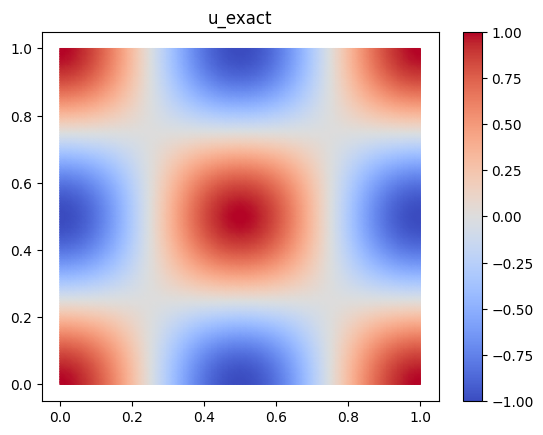

In [9]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
u_exact_plt = tripcolor(u_exact, axes=axes, cmap='coolwarm')
fig.colorbar(u_exact_plt)
plt.title("u_exact")
plt.show()

In [10]:
# Define variational problem
u = TrialFunction(P1)
v = TestFunction(P1)
a = dot(grad(u), grad(v))*dx + u*v*dx
L = f*v*dx

# Compute solution for Poisson equation
u_sol = Function(P1)
solve(a == L, u_sol)

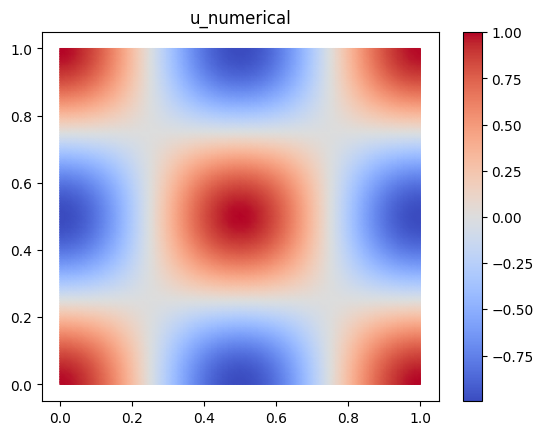

In [12]:
fig, axes = plt.subplots()
u_num_plt = tripcolor(u_sol, axes=axes, cmap='coolwarm')
fig.colorbar(u_num_plt)
plt.title("u_numerical")
plt.show()

In [13]:
u_grad_zz = recover_zz(u_sol)

In [14]:
# Calculate analytical gradient of u
u_grad_exact_expr = as_vector([-2 * pi * sin(2 * pi * x) * cos(2 * pi * y),
                                -2 * pi * cos(2 * pi * x) * sin(2 * pi * y)])
u_grad_exact = project(u_grad_exact_expr, P1_vec)

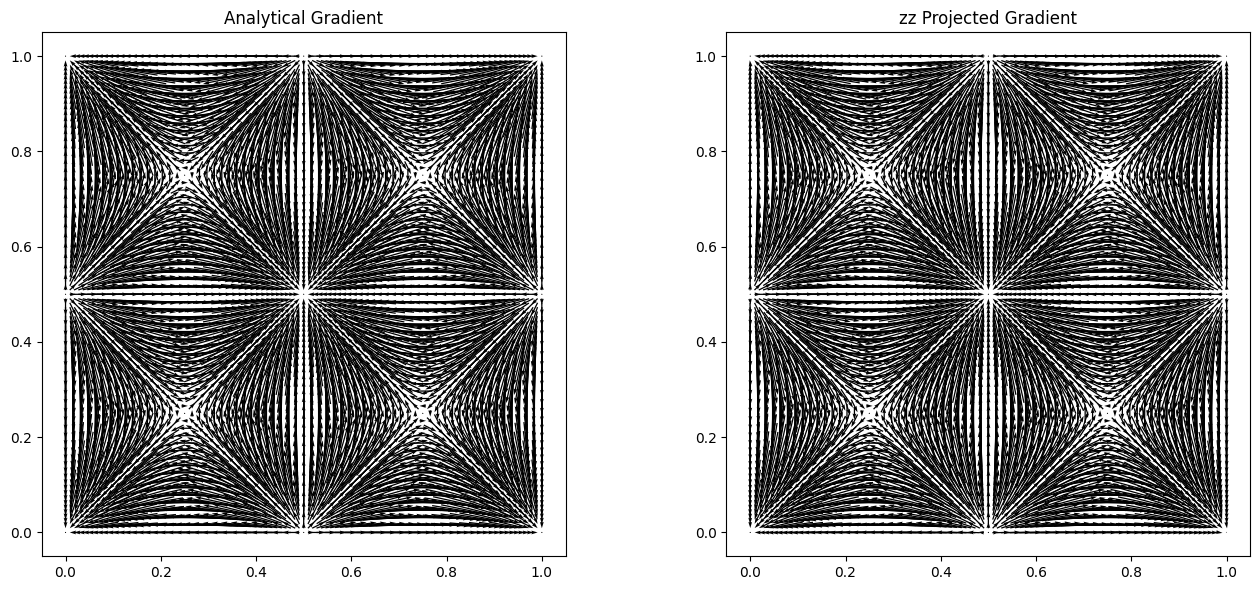

In [15]:
# Plot
# To visualize vectors using quiver plot
coords = mesh.coordinates.dat.data
u_vals_exact = u_grad_exact.dat.data
u_vals_zz = u_grad_zz.dat.data

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# Quiver plot for analytical gradient
axes[0].quiver(coords[:, 0], coords[:, 1], u_vals_exact[:, 0], u_vals_exact[:, 1], pivot='middle', scale=50)
axes[0].set_title('Analytical Gradient')
axes[0].set_aspect('equal')

# Quiver plot for L2 projected gradient
axes[1].quiver(coords[:, 0], coords[:, 1], u_vals_zz[:, 0], u_vals_zz[:, 1], pivot='middle', scale=50)
axes[1].set_title('zz Projected Gradient')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

In [16]:
# Compute the magnitudes of the gradients
u_grad_diff = Function(P1_vec).interpolate(u_grad_zz - u_grad_exact)
u_grad_diff_norm = Function(P1).interpolate(sqrt(dot(u_grad_diff, u_grad_diff)))
u_grad_diff_norm_max = max(u_grad_diff_norm.dat.data)
u_grad_diff_norm_min = min(u_grad_diff_norm.dat.data)

print("The norm of difference is %.2f to %.2f" % (u_grad_diff_norm_min, u_grad_diff_norm_max))


The norm of difference is 0.00 to 0.12


In [17]:
u_grad_diff_global = sum(u_grad_diff_norm.dat.data)
print("The global error is %.2f" % (u_grad_diff_global))

The global error is 146.03
